# Setup 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from collections import Counter
%matplotlib inline

In [5]:
X, y = datasets.make_blobs(n_samples = 100, n_features = 2, random_state = 32)

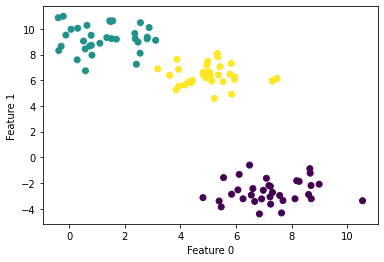

In [6]:
plt.scatter(X[:,0], X[:,1], c = y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Decision tree 

Splitting the training set in a way that produces the purest subsets.

No equations besides Gini, as it is much easier to understand just by looking at the code + the viz.

Gini impurity

$$
G_{i} = 1 - \sum_{k=1}^{m} p_{i,k}^{2}
$$

In [7]:
def gini(y):
    dist = (np.bincount(y) / len(y)) ** 2
    return 1 - sum(dist)

In [11]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        if not self.n_feats:
            self.n_feats = X.shape[1]
        else:
            min(self.n_feats, X.shape[1])
        self.root = self.grow_tree(X, y)

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            #get the most common label from the node
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self.best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self.split(X[:, best_feat], best_thresh)
        left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self.information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
                    
        #plot splits
        if split_idx == 1:
            plt.axhline(y = split_thresh, color = 'r', linestyle = '-')
            plt.axhspan(min(X[:,1]), split_thresh, facecolor='purple', alpha=0.1)
            plt.axhspan(split_thresh, max(X[:,1]), facecolor='green', alpha=0.1)
        else:
            plt.axvline(x = split_thresh, color = 'g')
        
        return split_idx, split_thresh

    def information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_gini = gini(y)

        # generate split
        left_idxs, right_idxs = self.split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = gini(y[left_idxs]), gini(y[right_idxs])
        child_gini = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_gini - child_gini
        return ig

    def split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

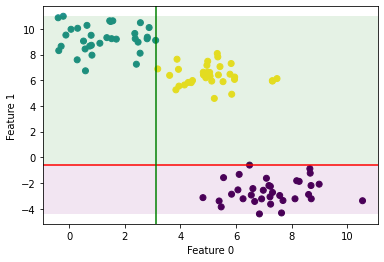

In [12]:
clf = DecisionTree(min_samples_split=2, max_depth=10)
clf.fit(X, y)

plt.scatter(X[:,0], X[:,1], c = y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()